In [1]:
import torch
import torch.nn.functional as F
import dgl
import pickle as pkl
import numpy as np
import networkx as nx
from copy import deepcopy

In [2]:
from xgnn_src.node.eval import extract_true_motif

In [3]:
def load_data(dataset):
    with open('./datasets/%s.g'%dataset, 'rb') as f:
        g = pkl.load(f)
    return g
        
def save_data(data, path):
    with open(path, 'wb') as f:
        pkl.dump(data, f)
    
def load_true_graphs(g, selected_node, offset, size=5):
    true_graphs = [extract_true_motif(g, i, offset, size) for i in selected_node]
    return true_graphs
        
def convert(g, true_graphs, norm_data=False):
    # adj
    adj = g.adj(scipy_fmt='coo')
    adj_dense = np.asarray(adj.todense())
    # feat
    if not norm_data:
        features = np.ones((g.num_nodes(), 10))
    else:
        features = g.ndata['feat'][:,:10].numpy()
    train_mask, val_mask, test_mask = g.ndata['train_mask'].numpy(), g.ndata['val_mask'].numpy(), g.ndata['test_mask'].numpy()
    y = F.one_hot(g.ndata['label']).to(torch.float32).numpy()
    y_train = deepcopy(y)
    y_train[~g.ndata['train_mask']] = 0.
    y_val = deepcopy(y)
    y_val[~g.ndata['val_mask']] = 0.
    y_test = deepcopy(y)
    y_test[~g.ndata['test_mask']] = 0.
    
    true_edges = [dg.edata['_ID'] for dg in true_graphs]
    true_edges = torch.hstack(true_edges).sort().values
    edge_labels = torch.zeros((g.num_edges(),))
    edge_labels[true_edges] = 1.
    g.edata['label'] = edge_labels
    elb_adj = deepcopy(adj)
    elb_adj.data = edge_labels.numpy()
    edge_label_matrix = np.asarray(elb_adj.todense())
    return adj_dense, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, edge_label_matrix

In [6]:
g = load_data('ba_shape_bidir')
true_graphs = load_true_graphs(g, list(range(300, 700, 5)), 299, 5)
data = convert(g, true_graphs)
save_data(data, './datasets/syn1.pkl')

In [16]:
cg = load_data('ba_community_bidir')
true_graphs1 = load_true_graphs(cg, list(range(300, 700, 5)), 299, 5)
true_graphs2 = load_true_graphs(cg, list(range(1000, 1400, 5)), 999, 5)
true_graphs = true_graphs1 + true_graphs2
data = convert(cg, true_graphs, norm_data=True)
save_data(data, './datasets/syn2.pkl')

In [7]:
tcg = load_data('tree_cycle_bidir')
true_graphs = load_true_graphs(tcg, list(range(511, 871, 6)), 510, 6)
data = convert(tcg, true_graphs)
save_data(data, './datasets/syn3.pkl')

In [4]:
tgg = load_data('tree_grid_bidir')
true_graphs = load_true_graphs(tgg, list(range(511, tgg.num_nodes(), 9)), 510, 9)
data = convert(tgg, true_graphs)
save_data(data, './datasets/syn4.pkl')

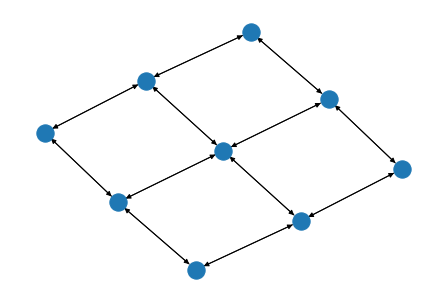

In [5]:
gx = dgl.to_networkx(true_graphs[0])
pos = nx.kamada_kawai_layout(gx)
nx.draw(gx, pos)

In [6]:
len(true_graphs)

80